In [3]:
# IMPORTS

import tensorflow as tf
import os
import pathlib
import time
import datetime
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from google.cloud import storage

In [1]:
photo_path_1 = os.path.join(os.getcwd(),"..","raw_data","photo","photo1")
sketch_path_1 = os.path.join(os.getcwd(),"..","raw_data","sketch","sketch1")

#Create two lists of the filenames in the corresponding paths and sort them
photo_list_1 = os.listdir(photo_path_1)
photo_list_1.sort()

sketch_list_1 = os.listdir(sketch_path_1)
sketch_list_1.sort()

NameError: name 'os' is not defined

In [ ]:
# load the dataset
data = load('maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

GENERATOR

In [4]:
OUTPUT_CHANNELS = 3

In [5]:
#ENCODEUR

def downsample(filters, size, apply_batchnorm=True):
    
    init = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=init, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    return result

In [6]:
#DECODEUR

def upsample(filters, size, apply_dropout=False):
    
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [7]:
#GENERATEUR FINAL

def Generator():
    
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    init = tf.random_normal_initializer(0., 0.02)

    down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

    up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

    
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=init,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model
    



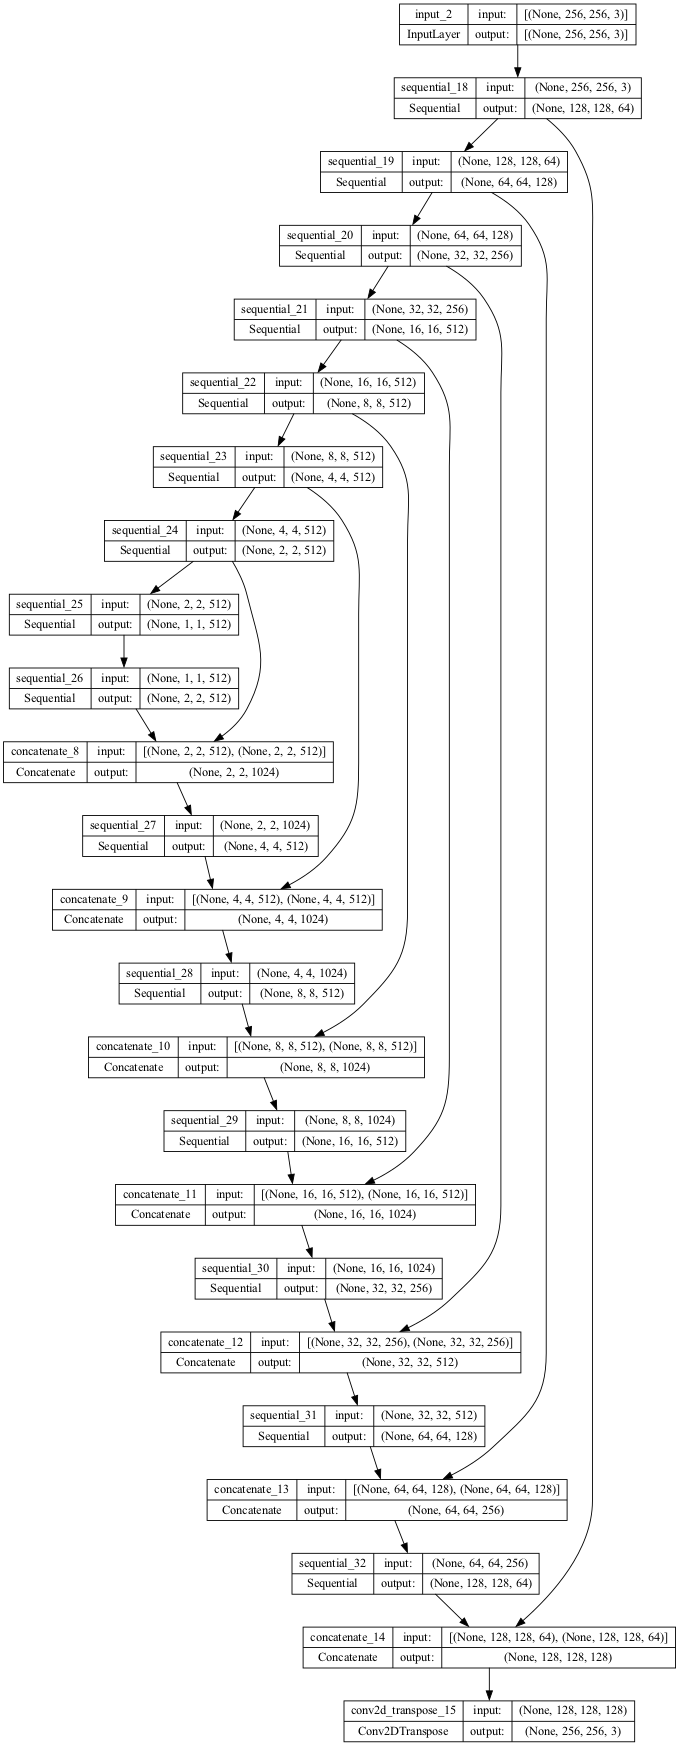

In [20]:
g_model = Generator()
tf.keras.utils.plot_model(g_model, show_shapes=True, dpi=64)

In [9]:
LAMBDA = 100

In [10]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

DISCRIMINATEUR

In [12]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
  
  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)
  
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  model = tf.keras.Model(inputs=[inp, tar], outputs=last) #define model 
  
  opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)
  model.compile(loss='binary_crossentropy', optimizer= opt, loss_weights = [0.5])
  
  return model

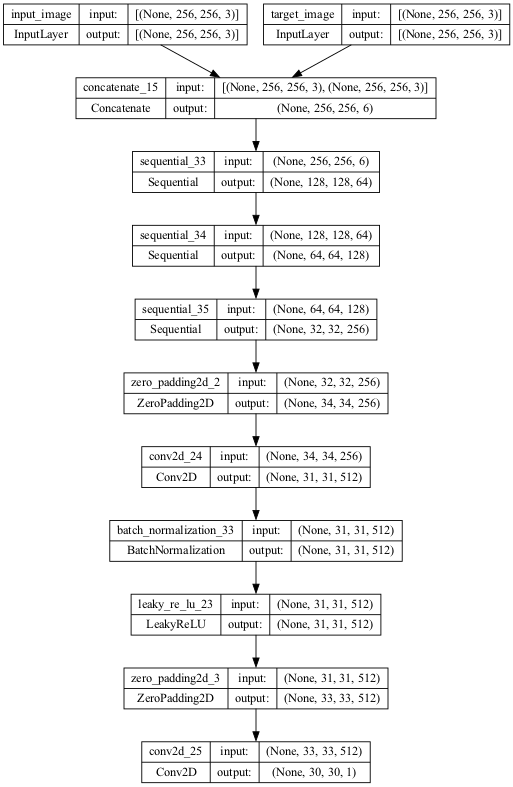

In [21]:
d_model = Discriminator()
tf.keras.utils.plot_model(d_model, show_shapes=True, dpi=64)

In [14]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

GAN FINAL

In [19]:
#GAN FINAL

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in Discriminator.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = tf.keras.Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = tf.keras.Model(in_src, [dis_out, gen_out])
	# compile model
	opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [16]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [17]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = np.randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [18]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
# train pix2pix model
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

In [38]:
# load image data
photo_path = "../data/preproc_photo/"
#Get the list of files in the path and sort it
photo_list = os.listdir(photo_path)
photo_list.sort()
photo_array= np.asarray([np.asarray(plt.imread(photo_path+image)) for image in photo_list])
photo_array

array([[[[ 50, 151, 117],
         [ 47, 148, 114],
         [ 46, 147, 113],
         ...,
         [ 73, 170, 116],
         [ 75, 169, 116],
         [ 76, 170, 117]],

        [[ 55, 156, 122],
         [ 53, 154, 120],
         [ 51, 152, 118],
         ...,
         [ 78, 175, 121],
         [ 79, 173, 120],
         [ 79, 173, 120]],

        [[ 56, 157, 123],
         [ 55, 156, 122],
         [ 54, 155, 121],
         ...,
         [ 84, 181, 127],
         [ 83, 177, 124],
         [ 82, 176, 123]],

        ...,

        [[101,  66,  47],
         [ 84,  49,  30],
         [105,  70,  51],
         ...,
         [ 80,  57,  39],
         [ 71,  54,  38],
         [ 68,  52,  37]],

        [[ 99,  62,  46],
         [101,  64,  46],
         [100,  63,  45],
         ...,
         [ 75,  56,  39],
         [ 65,  52,  36],
         [ 63,  51,  37]],

        [[ 96,  59,  43],
         [104,  67,  51],
         [ 88,  51,  33],
         ...,
         [ 72,  55,  37],
        

In [39]:
sketch_path = "../data/preproc_sketch/"
#Get the list of files in the path and sort it
sketch_list = os.listdir(sketch_path)
sketch_list.sort()
sketch_array= np.asarray([np.asarray(plt.imread(sketch_path+sketch)) for sketch in sketch_list])
sketch_array

array([[[[240, 240, 240],
         [242, 242, 242],
         [244, 244, 244],
         ...,
         [240, 240, 240],
         [244, 244, 244],
         [245, 245, 245]],

        [[247, 247, 247],
         [248, 248, 248],
         [249, 249, 249],
         ...,
         [222, 222, 222],
         [229, 229, 229],
         [238, 238, 238]],

        [[248, 248, 248],
         [249, 249, 249],
         [248, 248, 248],
         ...,
         [229, 229, 229],
         [230, 230, 230],
         [236, 236, 236]],

        ...,

        [[251, 251, 251],
         [252, 252, 252],
         [250, 250, 250],
         ...,
         [248, 248, 248],
         [249, 249, 249],
         [250, 250, 250]],

        [[249, 249, 249],
         [250, 250, 250],
         [249, 249, 249],
         ...,
         [247, 247, 247],
         [248, 248, 248],
         [249, 249, 249]],

        [[254, 254, 254],
         [251, 251, 251],
         [249, 249, 249],
         ...,
         [247, 247, 247],
        

In [43]:
X_train = photo_array[0:100].shape

(100, 256, 256, 3)

In [46]:
from numpy import load

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = filename
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]


dataset = photo_array[0:30], sketch_array[0:30]
dataset = (dataset - 127.5) / 127.5


TypeError: tuple indices must be integers or slices, not str

In [17]:
B = "egnahC your life, nrael to code"

B.split()


['egnahC', 'your', 'life,', 'nrael', 'to', 'code']

In [2]:
spinWords("Hey fellow Le Wagon alumni") => "Hey wollef Le nogaW inmula"
spinWords("Rake it until you make it") => "Rake it litnu you make it"
spinWords("Change your life, learn to code") => "egnahC your life, nrael to code"

SyntaxError: cannot assign to function call (148201139.py, line 1)

In [43]:
import re

def spinWords(sentence):
    A = re.findall(r"[\w']+|[.,!?;]", sentence)
    final = []
    for i in A:
        if len(i)>=5:
            final.append(i[::-1])
        else :
            final.append(i)
    return ' '.join(final)

In [45]:
spinWords("Rake it until you make it")

'Rake it litnu you make it'